# Analyzing Persuasion Scores of Context Types
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import warnings

# warnings.filterwarnings("ignore")
from ast import literal_eval
import json
import os
from pathlib import Path
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

from typing import List, Dict
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.53547376.kevidu/ipykernel_162591/3757544002.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pan

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [4]:
from analysis.analysis_helpers import (
    add_val_df_to_wandb,
    construct_df_given_query_id,
    explode_val_df_per_qe,
    load_val_df_from_wandb,
    permutation_test,
    percent_ents_passing_pscore_permutation_test,
)
from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from utils import (
    load_artifact_from_wandb,
    construct_paths_and_dataset_kwargs,
    infer_context_type,
)

### Preamble

#b40426


Text(0.5, 1.0, 'ABC123 vs $\\mathrm{ABC123}^{123}$')

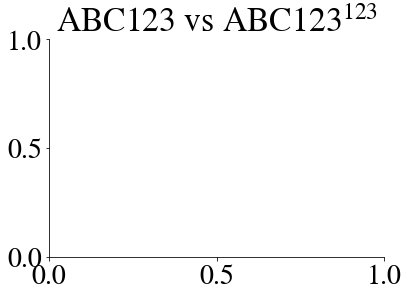

In [68]:
from mpl_styles import *

import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

cm = sns.color_palette("coolwarm_r", as_cmap=True)
cm.set_bad(cm(-np.inf))
print(matplotlib.colors.to_hex(cm(-np.inf)))
cm
# type(x)

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")

In [6]:
##############
# Parameters #
##############
CONFIG_PATH = "analysis/config-context-types.yml"
with open(CONFIG_PATH) as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Data parameters
DATASET_NAME = config["DATASET_NAME"]
RAW_DATA_PATH = config["RAW_DATA_PATH"]
SEED = config["SEED"]
MODEL_ID = config["MODEL_ID"]
LOAD_IN_8BIT = config["LOAD_IN_8BIT"]
MAX_CONTEXTS = config["MAX_CONTEXTS"]
MAX_ENTITIES = config["MAX_ENTITIES"]
CAP_PER_TYPE = config["CAP_PER_TYPE"]
ABLATE_OUT_RELEVANT_CONTEXTS = config["ABLATE_OUT_RELEVANT_CONTEXTS"]
UNIFORM_CONTEXTS = config["UNIFORM_CONTEXTS"]
DEDUPLICATE_ENTITIES = config["DEDUPLICATE_ENTITIES"]
ENTITY_SELECTION_FUNC_NAME = config["ENTITY_SELECTION_FUNC_NAME"]
ENTITY_TYPES = config["ENTITY_TYPES"]
QUERY_TYPES = config["QUERY_TYPES"]
CONTEXT_TYPES = config["CONTEXT_TYPES"]
ANSWER_MAP = config["ANSWER_MAP"]

DATASET_KWARGS = dict(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
    ENTITY_TYPES=ENTITY_TYPES,
    CONTEXT_TYPES=CONTEXT_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

In [7]:
# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join("analysis", "analysis-yago.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    # mode="disabled",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
2024-04-03 22:38:45.353589: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'nump

{'ENTITY_COLOR': [0.00392156862745098, 0.45098039215686275, 0.6980392156862745], 'CONTEXT_COLOR': [0.8705882352941177, 0.5607843137254902, 0.0196078431372549], 'OPEN_COLOR': [0.00784313725490196, 0.6196078431372549, 0.45098039215686275], 'CLOSED_COLOR': [0.8352941176470589, 0.3686274509803922, 0.0], 'LINE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'REAL_COLOR': [0.792156862745098, 0.5686274509803921, 0.3803921568627451], 'FAKE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'DIFF_COLOR': [0.984313725490196, 0.6862745098039216, 0.8941176470588236], 'CONFIG_PATH': 'analysis/config-context-types.yml', 'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec copy.json', 'SEED': 11, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 600, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': True, 'DEDUPLICATE_ENTITIES': True, 'ENTITY_SELECTION_FUNC_NAM

In [8]:
# # Downloads yago_qec.json from wandb (if not already cached there)
# artifact, files = load_artifact_from_wandb(
#     f"{DATASET_NAME}-yago_qec", save_dir=Path(RAW_DATA_PATH).parent
# )
# artifact.name

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [9]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [10]:
query_ids = list(yago_qec.keys())
for qid, v in list(yago_qec.items())[:10]:
    print(qid, len(v["entities"]), len(set(v["entities"])))

http://schema.org/about 954 947
http://schema.org/actor 1000 991
http://schema.org/address 1000 997
http://schema.org/administrates 998 798
http://schema.org/affiliation 994 962
http://schema.org/alumniOf 1000 999
http://schema.org/author 1000 997
http://schema.org/award 666 663
http://schema.org/birthDate 1000 999
http://schema.org/birthPlace 1000 1000


In [11]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME, MODEL_ID, str(SEED))
os.makedirs(analysis_dir, exist_ok=True)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ/EleutherAI/pythia-6.9b-deduped/11


In [12]:
# Set random seeds
# torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Load Data

In [13]:
# qid_to_artifact_path = {
#     query_id: add_val_df_to_wandb(
#         yago_qec=yago_qec,
#         **DATASET_KWARGS,
#         QUERY_ID=query_id,
#     )
#     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
#     for query_id in tqdm(query_ids)
# }

In [14]:
# query_ids = list(
#     set(query_ids).difference(
#         [
#             # "http://yago-knowledge.org/resource/studentsCount",
#             # "http://schema.org/numberOfPages",
#             "http://yago-knowledge.org/resource/distanceFromEarth",
#             # "http://schema.org/numberOfEmployees",
#             # "http://schema.org/numberOfEpisodes",
#             # "http://schema.org/numberOfSeasons",
#             # "http://schema.org/humanDevelopmentIndex",
#             "http://schema.org/duns",
#             # "http://schema.org/duration",
#             "http://schema.org/unemploymentRate",
#             "http://yago-knowledge.org/resource/radialVelocity",
#             # "http://schema.org/populationNumber",
#             "http://yago-knowledge.org/resource/luminosity",
#             "http://yago-knowledge.org/resource/parallax",
#             "http://yago-knowledge.org/resource/length",
#             "http://schema.org/elevation",
#             # "http://yago-knowledge.org/resource/sportNumber",
#             "http://yago-knowledge.org/resource/mass",
#         ]
#         # [
#         #     "http://yago-knowledge.org/resource/studentsCount",
#         #     "http://schema.org/numberOfPages",
#         #     "http://yago-knowledge.org/resource/distanceFromEarth",
#         #     "http://schema.org/numberOfEmployees",
#         #     "http://schema.org/numberOfEpisodes",
#         #     "http://schema.org/numberOfSeasons",
#         #     "http://schema.org/humanDevelopmentIndex",
#         #     "http://schema.org/duns",
#         #     "http://schema.org/duration",
#         #     "http://schema.org/unemploymentRate",
#         #     "http://yago-knowledge.org/resource/radialVelocity",
#         #     "http://schema.org/populationNumber",
#         #     "http://yago-knowledge.org/resource/luminosity",
#         #     "http://yago-knowledge.org/resource/parallax",
#         #     "http://yago-knowledge.org/resource/length",
#         #     "http://schema.org/elevation",
#         #     "http://yago-knowledge.org/resource/sportNumber",
#         #     "http://yago-knowledge.org/resource/mass",
#         # ]
#     )
# )
# # qid_to_results_paths = {
# #     query_id: load_val_df_from_wandb(
# #         **DATASET_KWARGS,
# #         QUERY_ID=query_id,
# #         verbose=False,
# #         overwrite_df=True,
# #     )
# #     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
# #     for query_id in tqdm(query_ids)
# # }

In [15]:
construct_df_given_query_id(
    yago_qec=yago_qec,
    **DATASET_KWARGS,
    QUERY_ID="http://schema.org/actor",
    verbose=False,
    overwrite_df=True,
).info()

Computing val_df_per_qe for http://schema.org/actor.
Unable to find mr_results_path at data/YagoECQ/schema_actor/schema_actor-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-6.9b-deduped-8bit/results/mr.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_actor/schema_actor-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-6.9b-deduped-8bit/results/mr.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   q_id                   400 non-null    object 
 1   query_form             400 non-null    object 
 2   entity                 400 non-null    object 
 3   answer                 400 non-null    object

In [16]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(
        yago_qec=yago_qec,
        **DATASET_KWARGS,
        QUERY_ID=query_id,
        verbose=False,
        overwrite_df=False,
    )
    # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
    for query_id in tqdm(query_ids)
}

 19%|█▉        | 24/125 [00:55<03:52,  2.30s/it]

Computing val_df_per_qe for http://schema.org/gtin.
Unable to find file at data/YagoECQ/schema_gtin/schema_gtin-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_gtin/schema_gtin-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 35%|███▌      | 44/125 [01:41<03:17,  2.43s/it]

Computing val_df_per_qe for http://schema.org/motto.
Unable to find file at data/YagoECQ/schema_motto/schema_motto-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_motto/schema_motto-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 52%|█████▏    | 65/125 [02:33<02:34,  2.58s/it]

Computing val_df_per_qe for http://schema.org/url.
Unable to find file at data/YagoECQ/schema_url/schema_url-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_url/schema_url-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


100%|██████████| 125/125 [05:16<00:00,  2.53s/it]


In [17]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/url', 'http://schema.org/motto', 'http://schema.org/gtin'}


In [18]:
# # Temporary fix for yago_qec and df having different lists of fake entiites
# for qid, val_df_per_qe in qid_to_val_df_per_qe.items():
#     val_df_per_qe["type"] = val_df_per_qe["type"].fillna("gpt_fake_entities")
#     qid_to_val_df_per_qe[qid] = val_df_per_qe

In [19]:
# Snapshot
val_df_per_qe = qid_to_val_df_per_qe["http://schema.org/lyricist"]
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[3]].sort_values(
    "susceptibility_score"
).head()

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds
323,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Gott erhalte Franz den Kaiser,)",Lorenz Leopold Haschka,"[Definitely, a lyricist for 'A Twilight Aria' ...","[0.9666266441345215, 0.36806392669677734, 0.70...","[0.9266344013977521, 0.4497074670506917, 0.287...",entities,0.781295,{'http://schema.org/CreativeWork': 0.740740740...,open,"[204, 205, 206, 207, 208, 209]"
308,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Amhrán na bhFiann,)",Peadar Kearney,"[Definitely, a lyricist for 'A Twilight Aria' ...","[0.9550013542175293, 0.6944608688354492, 0.818...","[0.6771703392503002, 0.5556867328291794, 0.367...",entities,0.855420,{'http://schema.org/CreativeWork': 0.740740740...,open,"[18, 19, 20, 21, 22, 23]"
346,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Lucy in the Sky with Diamonds,)",John Lennon,"[Definitely, a lyricist for 'A Twilight Aria' ...","[0.9204211235046387, 0.4143691062927246, 1.267...","[0.3241370737921984, 0.4810928982862193, 0.485...",entities,0.864727,{'http://schema.org/CreativeWork': 0.740740740...,open,"[294, 295, 296, 297, 298, 299]"
331,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Take Me Home, Country Roads,)",Bill Danoff,"[Definitely, a lyricist for 'A Twilight Aria' ...","[2.0621469020843506, 0.42618274688720703, 1.95...","[0.665550649639499, 0.32536955320072924, 0.441...",entities,0.882160,{'http://schema.org/CreativeWork': 0.740740740...,open,"[414, 415, 416, 417, 418, 419]"
334,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Mamma Mia!,)",Benny Andersson,"[Definitely, a lyricist for 'A Twilight Aria' ...","[1.057966709136963, 0.8738312721252441, 1.6192...","[0.43531595284300634, 0.7892752971403019, 0.64...",entities,0.948914,{'http://schema.org/CreativeWork': 0.740740740...,open,"[300, 301, 302, 303, 304, 305]"


In [20]:
pd.concat(list(qid_to_val_df_per_qe.values()))[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "type",
        "susceptibility_score",
        "entity_classes",
        "query_type",
    ]
].to_csv("sus_scores_all.csv", index=False)

### Optionally, filter out fake entities that appear in the training data

In [21]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
FAKE_ENTITY_FREQ_THRESHOLD = (
    0  # filter out any fake entities with frequency greater than this
)
# FAKE_ENTITY_FREQ_THRESHOLD = np.inf # don't filter at all

df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
for qid, df in tqdm(qid_to_val_df_per_qe.items()):
    qid_to_val_df_per_qe[qid] = df[
        df.apply(
            lambda x: x["type"] == "entities"
            or fake_ent_freqs_dict.get(x["entity"][0], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
            axis=1,
        )
    ]

print([len(df) for df in qid_to_val_df_per_qe.values()])
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

100%|██████████| 122/122 [00:00<00:00, 152.97it/s]


[376, 392, 328, 320, 288, 312, 384, 312, 312, 312, 312, 392, 348, 312, 312, 284, 396, 336, 336, 388, 388, 296, 392, 336, 328, 312, 336, 344, 300, 396, 396, 312, 388, 376, 304, 300, 332, 376, 316, 388, 400, 396, 312, 384, 312, 292, 320, 380, 400, 388, 308, 392, 316, 324, 392, 304, 336, 300, 348, 392, 312, 392, 300, 316, 304, 316, 316, 312, 308, 392, 372, 300, 312, 300, 392, 308, 300, 300, 312, 300, 300, 392, 312, 300, 312, 324, 300, 320, 300, 312, 312, 312, 300, 312, 308, 324, 320, 312, 328, 344, 312, 328, 344, 340, 392, 312, 328, 340, 392, 312, 328, 396, 332, 312, 300, 396, 300, 360, 392, 308, 292, 300]


### Susceptibility Scores: real vs fake

In [22]:
from analysis_helpers import (
    compute_ttest_scores_dfs,
    save_ttest_df_to_json,
    count_open_closed_sig_group_match,
    count_num_significant_queries,
    combine_open_and_closed_dfs,
    write_to_latex_test_results_by_qid,
    write_to_latex_test_sus_and_per_results_by_qid,
    explode_val_df_per_qe,
)

In [23]:
ttest_res_open_sus_df, ttest_res_closed_sus_df = compute_ttest_scores_dfs(
    qid_to_val_df_per_qe,
    group1="entities",
    group2="gpt_fake_entities",
    score_col="susceptibility_score",
    permutations=10000,
)

100%|██████████| 122/122 [00:08<00:00, 14.32it/s]


In [24]:
save_ttest_df_to_json(
    ttest_res_open_sus_df,
    ttest_res_closed_sus_df,
    qid_to_val_df_per_qe,
    analysis_dir=analysis_dir,
    filename="qid_to_sus_ttest_res_and_entities.json",
)

analysis/YagoECQ/EleutherAI/pythia-6.9b-deduped/11/qid_to_sus_ttest_res_and_entities.json


In [25]:
# Number of queries with matching significance results
count_open_closed_sig_group_match(ttest_res_open_sus_df, ttest_res_closed_sus_df)

,query,open,closed
1,http://schema.org/ownedBy,less,less
2,http://yago-knowledge.org/resource/distanceFro...,less,less
3,http://schema.org/illustrator,less,less
5,http://schema.org/iataCode,less,less
6,http://schema.org/founder,less,less
...,...,...,...
110,reverse-http://yago-knowledge.org/resource/con...,not,not
113,http://yago-knowledge.org/resource/consumes,not,not
116,reverse-http://yago-knowledge.org/resource/rep...,not,not
120,reverse-http://schema.org/performer,more,more


In [26]:
# Number and proportion of queries that are significant
print(
    "Open:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_open_sus_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)
print("\n")
print(
    "Closed:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_closed_sus_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)

Open:
{
  "count": {
    "significant (less)": 57,
    "insignificant": 65
  },
  "proportion": {
    "significant (less)": 0.4672131147540984,
    "insignificant": 0.5327868852459017
  }
}


Closed:
{
  "count": {
    "significant (less)": 47,
    "insignificant": 75
  },
  "proportion": {
    "significant (less)": 0.38524590163934425,
    "insignificant": 0.6147540983606558
  }
}


In [27]:
sus_score_test_results_by_qid = combine_open_and_closed_dfs(
    ttest_res_open_sus_df, ttest_res_closed_sus_df
)
sus_score_test_results_by_qid

Open              Closed        
                 Cohen's $d$     $p$ Cohen's $d$     $p$
Query                                                   
about               0.019623  0.5544   -0.382451  0.0051
academicDegree     -0.119443  0.2430   -0.501007  0.0036
actor              -1.898158  0.0000   -0.190876  0.0894
address            -0.330559  0.0194    0.043635  0.6092
administrates       0.218092  0.9020   -0.635561  0.0001
...                      ...     ...         ...     ...
studentOf          -0.469149  0.0043   -0.222647  0.0976
studentsCount      -0.596798  0.0004    0.765390  1.0000
terminus            0.212625  0.8847   -1.080834  0.0000
unemploymentRate   -0.411666  0.0101    1.179497  1.0000
worksFor           -0.399704  0.0091   -0.488364  0.0013

[122 rows x 4 columns]

In [28]:
print(
    write_to_latex_test_results_by_qid(
        sus_score_test_results_by_qid,
        analysis_dir=analysis_dir,
        filename="sus_score_test_results_by_qid.tex",
    )[:500]
)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{c}{Open} & \multicolumn{2}{c}{Closed} \\
 & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ \\
Query &  &  &  &  \\
\midrule
about & 0.02 & 0.55 & -0.38 & 0.01 \\
academicDegree & -0.12 & 0.24 & -0.50 & 0.00 \\
actor & -1.90 & 0.00 & -0.19 & 0.09 \\
address & -0.33 & 0.02 & 0.04 & 0.61 \\
administrates & 0.22 & 0.90 & -0.64 & 0.00 \\
affiliation & -0.26 & 0.07 & -0.02 & 0.45 \\
alumniOf & -0.24 & 0.08 & -0.29 & 0.04 \\
appearsIn & -0.42 & 0.01 & 0.02 & 0.


/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/tmp.53547376.kevidu/ipykernel_162591/1008532667.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=["(a)", "(b)"])


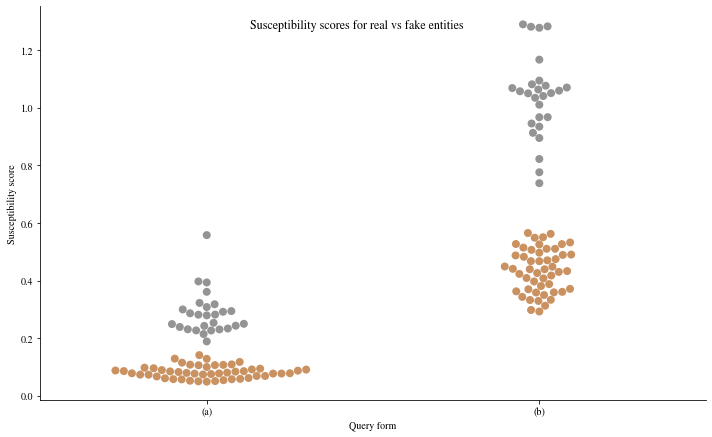

In [29]:
colormap = {
    "entities": REAL_COLOR,
    "gpt_fake_entities": FAKE_COLOR,
}

qt_to_qids = {
    "open": "http://schema.org/officialLanguage",
}
qt_to_dfs = {qt: qid_to_val_df_per_qe[qid] for qt, qid in qt_to_qids.items()}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6.5))

for i, (qt, df) in enumerate(qt_to_dfs.items()):
    plot = sns.swarmplot(
        data=df[df["query_type"] == qt],
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        size=8,
        # hue="is_real",
        # dodge=True,
        hue_order=ENTITY_TYPES,
        legend=None,
        palette=[colormap[e] for e in ENTITY_TYPES],
        # jitter=0.1,
        # legend="full",
    )
    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(15)
    ax.set(xticklabels=["(a)", "(b)"])
ax.set_xlabel("Query form")
ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility scores for real vs fake entities", y=0.9)
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 26.0% of the point

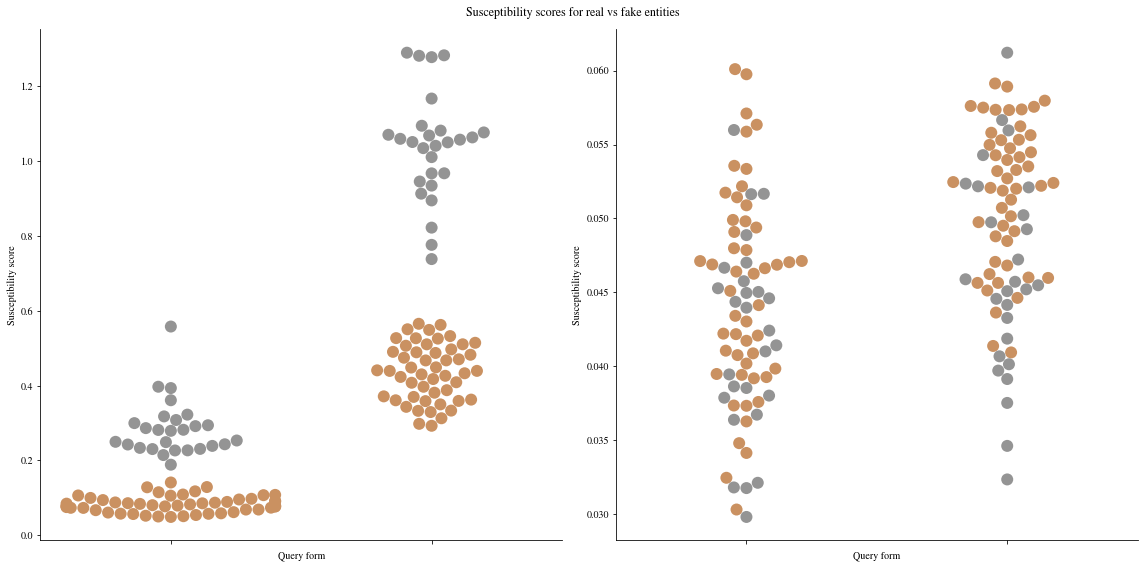

In [30]:
qt_to_qids = {
    "open": "http://schema.org/officialLanguage",
    "closed": "http://schema.org/officialLanguage",
}
qt_to_dfs = {qt: qid_to_val_df_per_qe[qid] for qt, qid in qt_to_qids.items()}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for i, (qt, df) in enumerate(qt_to_dfs.items()):
    ax = axes[i]
    plot = sns.swarmplot(
        data=df[df["query_type"] == qt],
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        size=12,
        # hue="is_real",
        # dodge=True,
        hue_order=ENTITY_TYPES,
        legend=None,
        palette=[colormap[e] for e in ENTITY_TYPES],
        # jitter=0.1,
        # legend="full",
    )
    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(15)
    ax.set(xticklabels=[])
    ax.set_xlabel("Query form")
    ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility scores for real vs fake entities")
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

<Axes: xlabel='type', ylabel='susceptibility_score'>

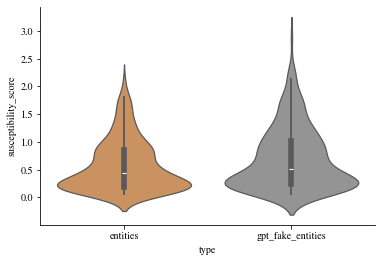

In [31]:
# Average sus score across all queries
val_dfs_all = pd.concat(list(qid_to_val_df_per_qe.values()), axis=0)
val_dfs_all
sus_scores_per_query_real_fake = (
    val_dfs_all.groupby(["q_id", "query_form", "query_type", "type"])
    .agg({"susceptibility_score": "mean"})
    .reset_index()
)
sns.violinplot(
    data=sus_scores_per_query_real_fake[
        sus_scores_per_query_real_fake["query_type"] == "open"
    ],
    x="type",
    y="susceptibility_score",
    hue="type",
    saturation=1.0,
    palette=[colormap[e] for e in ENTITY_TYPES],
)

/scratch/tmp.53547376.kevidu/ipykernel_162591/2959530097.py:22: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.violinplot(


<Axes: xlabel='type', ylabel='diff'>

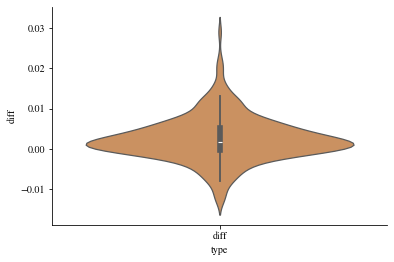

In [32]:
# Plot diff
sus_scores_per_query_fake = (
    sus_scores_per_query_real_fake[
        sus_scores_per_query_real_fake["type"] == "gpt_fake_entities"
    ]
    .sort_values(["q_id", "query_form", "query_type", "type"])
    .reset_index(drop=True)
)
sus_scores_per_query_fake
sus_scores_per_query_real = (
    sus_scores_per_query_real_fake[sus_scores_per_query_real_fake["type"] == "entities"]
    .sort_values(["q_id", "query_form", "query_type", "type"], inplace=False)
    .reset_index(drop=True)
)
sus_scores_per_query_real
sus_scores_per_query_fake["diff"] = (
    sus_scores_per_query_fake["susceptibility_score"]
    - sus_scores_per_query_real["susceptibility_score"]
)
sus_scores_per_query_fake["type"] = "diff"
sus_scores_per_query_fake
sns.violinplot(
    data=sus_scores_per_query_fake[sus_scores_per_query_fake["query_type"] == "closed"],
    x="type",
    y="diff",
    hue="type",
    saturation=1.0,
    palette=[colormap[e] for e in ENTITY_TYPES],
)

In [33]:
# # Plot every 10th query swarmplot, increasing according to the p-value
# qid_to_df_and_open_pvals = {
#     ttest_res_open_sus_df.iloc[i]["query"]: (
#         ttest_res_open_sus_df.iloc[i]["p_value"],
#         qid_to_val_df_per_qe[ttest_res_open_sus_df.iloc[i]["query"]],
#     )
#     for i in range(0, len(ttest_res_open_sus_df), 10)
# }

# fig, axes = plt.subplots(
#     nrows=len(qid_to_df_and_open_pvals), ncols=1, figsize=(10, 120)
# )

# for i, (qid, (p_value, df)) in enumerate(qid_to_df_and_open_pvals.items()):
#     ax = axes[i]
#     plot = sns.swarmplot(
#         # data=val_df_per_qe[val_df_per_qe["query_type"] == "closed"],
#         data=df[df["query_type"] == "open"],
#         x="query_form",
#         y="susceptibility_score",
#         hue="type",
#         ax=ax,
#         size=12,
#         dodge=True,
#         hue_order=ENTITY_TYPES,
#         palette=[colormap[e] for e in ENTITY_TYPES],
#     )
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(15)
#     ax.set_xlabel("Query form")
#     ax.set_ylabel("Susceptibility score")
#     ax.set_title(f"qid={qid}, pval={p_value:.3f}")
# fig.suptitle("Susceptibility scores for real entities vs fake entities")
# plt.tight_layout()
# plot_name = f"plot_susscore_vs_queryform_real_fake_open_increasing_pval"
# save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
# fig.savefig(save_path, bbox_inches="tight")

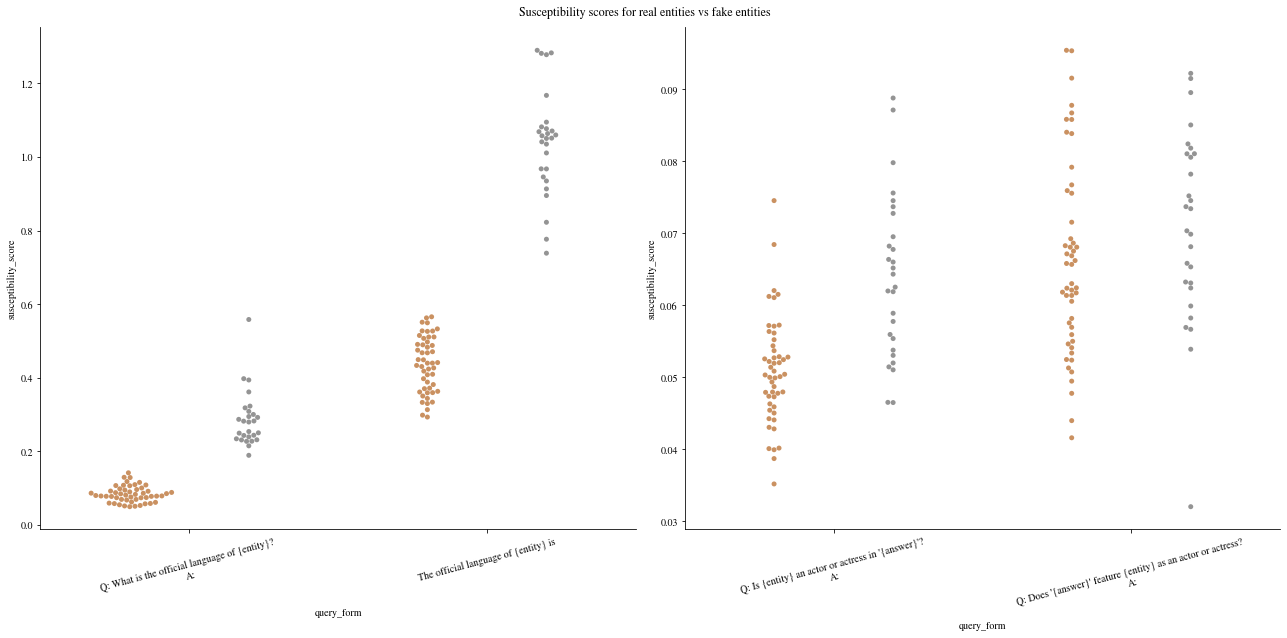

In [34]:
qt_to_qids = {
    "open": "http://schema.org/officialLanguage",
    "closed": "reverse-http://schema.org/actor",
}
qt_to_dfs = {qt: qid_to_val_df_per_qe[qid] for qt, qid in qt_to_qids.items()}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))

for i, (qt, df) in enumerate(qt_to_dfs.items()):
    ax = axes[i]
    plot = sns.swarmplot(
        # data=val_df_per_qe[val_df_per_qe["query_type"] == "closed"],
        data=df[df["query_type"] == qt],
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        # size=5,
        # hue="is_real",
        dodge=True,
        hue_order=ENTITY_TYPES,
        palette=[colormap[e] for e in ENTITY_TYPES],
        # jitter=0.1,
        legend=None,
    )
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
fig.suptitle("Susceptibility scores for real entities vs fake entities")
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_open_and_closed"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
# wandb.log({plot_name: wandb.Image(fig)})
# df.iloc[0]["contexts"]

### Persuasion scores (relevant vs irrelevant)

In [35]:
df["relevant_context_inds"].iloc[0]

[12, 13, 14, 15, 16, 17]

In [36]:
df

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds
0,reverse-http://schema.org/actor,Q: Is {entity} an actor or actress in '{answer...,"(Angela Merkel,)",An Inconvenient Sequel: Truth to Power,"[Definitely, Alonzo Serrato acts in Eyeball.\n...","[0.05419301986694336, 0.24010109901428223, -0....","[0.06557501147350164, 0.05166626312872071, 0.0...",entities,0.055201,{'http://schema.org/Person': 1.0},closed,"[12, 13, 14, 15, 16, 17]"
1,reverse-http://schema.org/actor,Q: Is {entity} an actor or actress in '{answer...,"(Robert De Niro,)",The Movies That Made Us,"[Definitely, Alonzo Serrato acts in Eyeball.\n...","[-0.02956247329711914, -0.04810190200805664, 0...","[0.07080120644800905, 0.08713643980742451, 0.0...",entities,0.061501,{'http://schema.org/Person': 1.0},closed,"[456, 457, 458, 459, 460, 461]"
2,reverse-http://schema.org/actor,Q: Is {entity} an actor or actress in '{answer...,"(Prem Nazir,)",Agniputhri,"[Definitely, Alonzo Serrato acts in Eyeball.\n...","[-0.03914928436279297, 0.08345627784729004, -0...","[0.057696635758496435, 0.05395034956766966, 0....",entities,0.052536,{'http://schema.org/Person': 1.0},closed,"[402, 403, 404, 405, 406, 407]"
3,reverse-http://schema.org/actor,Q: Is {entity} an actor or actress in '{answer...,"(Christopher Lee,)",Wyrd Sisters,"[Definitely, Alonzo Serrato acts in Eyeball.\n...","[0.2168576717376709, 0.07184433937072754, 0.10...","[0.03216155790674942, 0.03544004706499343, 0.0...",entities,0.040068,{'http://schema.org/Person': 1.0},closed,"[72, 73, 74, 75, 76, 77]"
4,reverse-http://schema.org/actor,Q: Is {entity} an actor or actress in '{answer...,"(Oliver Hardy,)",Hats Off,"[Definitely, Alonzo Serrato acts in Eyeball.\n...","[0.10132241249084473, 0.15566301345825195, 0.1...","[0.07637320566590805, 0.038944977469607796, 0....",entities,0.052788,{'http://schema.org/Person': 1.0},closed,"[366, 367, 368, 369, 370, 371]"
...,...,...,...,...,...,...,...,...,...,...,...,...
392,reverse-http://schema.org/actor,{entity} acts in,"(Nestor Carvajal,)",Fast Five,"[Definitely, Alonzo Serrato acts in Eyeball.\n...","[-0.12369346618652344, 1.8422017097473145, -0....","[0.6865558681760567, 1.791512962221936, 0.5939...",gpt_fake_entities,1.099350,{'http://schema.org/Person': 1.0},open,"[348, 349, 350, 351, 352, 353]"
394,reverse-http://schema.org/actor,{entity} acts in,"(Bhavana Chatterjee,)",The Medusa Touch,"[Definitely, Alonzo Serrato acts in Eyeball.\n...","[-0.4492182731628418, 0.6237912178039551, -0.1...","[0.46592923334499264, 0.6624181678792352, 0.56...",gpt_fake_entities,0.979238,{'http://schema.org/Person': 1.0},open,"[48, 49, 50, 51, 52, 53]"
396,reverse-http://schema.org/actor,{entity} acts in,"(Xena Constantinou,)",Azumi 2: Death or Love,"[Definitely, Alonzo Serrato acts in Eyeball.\n...","[-0.1698474884033203, 0.5225763320922852, -0.3...","[0.7513895418911453, 0.5813961378158097, 0.457...",gpt_fake_entities,1.023522,{'http://schema.org/Person': 1.0},open,"[576, 577, 578, 579, 580, 581]"
397,reverse-http://schema.org/actor,{entity} acts in,"(Gaëtan Blanchet,)",Fun with Dick and Jane,"[Definitely, Alonzo Serrato acts in Eyeball.\n...","[-0.22267866134643555, 2.09122371673584, -0.23...","[0.6003757552704369, 1.7516290036080298, 0.440...",gpt_fake_entities,0.973958,{'http://schema.org/Person': 1.0},open,"[144, 145, 146, 147, 148, 149]"


In [37]:
infer_context_type(
    "'China' is about Beijing.\n",
    yago_qec["http://schema.org/about"]["context_templates"],
)

('base', "'{entity}' is about {answer}.\n")

In [38]:
def mean_relevant_and_irrelevant_persuasion_scores(
    persuasion_scores: List[float], relevant_context_inds: List[int]
):
    persuasion_scores = np.array(persuasion_scores)

    relevant_p_scores = persuasion_scores[relevant_context_inds]
    irrelevant_p_scores = np.delete(persuasion_scores, relevant_context_inds)
    return (
        np.mean(relevant_p_scores),
        np.mean(irrelevant_p_scores),
        relevant_p_scores,
        irrelevant_p_scores,
    )


for query_id, df in tqdm(qid_to_val_df_per_qe.items()):
    df["mean_relevant_p_score"] = df.apply(
        lambda x: mean_relevant_and_irrelevant_persuasion_scores(
            x["persuasion_scores_kl"], x["relevant_context_inds"]
        )[0],
        axis=1,
    )
    df["mean_irrelevant_p_score"] = df.apply(
        lambda x: mean_relevant_and_irrelevant_persuasion_scores(
            x["persuasion_scores_kl"], x["relevant_context_inds"]
        )[1],
        axis=1,
    )
    df["relevant_p_scores"] = df.apply(
        lambda x: mean_relevant_and_irrelevant_persuasion_scores(
            x["persuasion_scores_kl"], x["relevant_context_inds"]
        )[2],
        axis=1,
    )
    df["irrelevant_p_scores"] = df.apply(
        lambda x: mean_relevant_and_irrelevant_persuasion_scores(
            x["persuasion_scores_kl"], x["relevant_context_inds"]
        )[3],
        axis=1,
    )
    context_types = [
        infer_context_type(c, yago_qec[query_id]["context_templates"])[0]
        for c in df["contexts"].iloc[0]
    ]
    df["context_types"] = df.apply(
        lambda x: context_types,
        axis=1,
    )
    qid_to_val_df_per_qe[query_id] = df


qid_to_pscore_df = {
    qid: df[
        ["query_type", "query_form", "mean_relevant_p_score", "mean_irrelevant_p_score"]
    ].melt(
        id_vars=["query_type", "query_form"],
        var_name="type",
        value_name="persuasion_score",
    )
    for qid, df in qid_to_val_df_per_qe.items()
}

 32%|███▏      | 39/122 [00:03<00:06, 12.15it/s]/scratch/tmp.53547376.kevidu/ipykernel_162591/1403099249.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mean_relevant_p_score"] = df.apply(
/scratch/tmp.53547376.kevidu/ipykernel_162591/1403099249.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mean_irrelevant_p_score"] = df.apply(
/scratch/tmp.53547376.kevidu/ipykernel_162591/1403099249.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [39]:
explode_val_df_per_qe(
    qid_to_val_df_per_qe[query_id],
    columns=["contexts", "persuasion_scores_kl", "context_types"],
)

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds,mean_relevant_p_score,mean_irrelevant_p_score,relevant_p_scores,irrelevant_p_scores,context_types
0,reverse-http://yago-knowledge.org/resource/ter...,Q: Is {entity} the terminus of {answer}?\nA:,"(London,)",A127 road,"Definitely, Altitude Allies is the terminus of...","[-0.1868743896484375, -0.12591814994812012, 0....",0.085517,entities,0.063357,{'http://schema.org/Organization': 0.404761904...,closed,"[252, 253, 254, 255, 256, 257]",0.069700,0.063293,"[0.08912117328675814, 0.10798273454476275, 0.0...","[0.08551706657759572, 0.08265834092337264, 0.0...",assertive
0,reverse-http://yago-knowledge.org/resource/ter...,Q: Is {entity} the terminus of {answer}?\nA:,"(London,)",A127 road,"Definitely, Altitude Allies is the terminus of...","[-0.1868743896484375, -0.12591814994812012, 0....",0.082658,entities,0.063357,{'http://schema.org/Organization': 0.404761904...,closed,"[252, 253, 254, 255, 256, 257]",0.069700,0.063293,"[0.08912117328675814, 0.10798273454476275, 0.0...","[0.08551706657759572, 0.08265834092337264, 0.0...",assertive
0,reverse-http://yago-knowledge.org/resource/ter...,Q: Is {entity} the terminus of {answer}?\nA:,"(London,)",A127 road,Altitude Allies is the terminus of European ro...,"[-0.1868743896484375, -0.12591814994812012, 0....",0.047772,entities,0.063357,{'http://schema.org/Organization': 0.404761904...,closed,"[252, 253, 254, 255, 256, 257]",0.069700,0.063293,"[0.08912117328675814, 0.10798273454476275, 0.0...","[0.08551706657759572, 0.08265834092337264, 0.0...",base
0,reverse-http://yago-knowledge.org/resource/ter...,Q: Is {entity} the terminus of {answer}?\nA:,"(London,)",A127 road,Altitude Allies is the terminus of California ...,"[-0.1868743896484375, -0.12591814994812012, 0....",0.033522,entities,0.063357,{'http://schema.org/Organization': 0.404761904...,closed,"[252, 253, 254, 255, 256, 257]",0.069700,0.063293,"[0.08912117328675814, 0.10798273454476275, 0.0...","[0.08551706657759572, 0.08265834092337264, 0.0...",base
0,reverse-http://yago-knowledge.org/resource/ter...,Q: Is {entity} the terminus of {answer}?\nA:,"(London,)",A127 road,Altitude Allies is not the terminus of Express...,"[-0.1868743896484375, -0.12591814994812012, 0....",0.059603,entities,0.063357,{'http://schema.org/Organization': 0.404761904...,closed,"[252, 253, 254, 255, 256, 257]",0.069700,0.063293,"[0.08912117328675814, 0.10798273454476275, 0.0...","[0.08551706657759572, 0.08265834092337264, 0.0...",negation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Paradox Harbor,)",European route E574,"Definitely, Zephyr's Reach is the terminus of ...","[2.708249092102051, 1.5543444156646729, 3.2113...",5.517948,gpt_fake_entities,2.332830,{'http://schema.org/Organization': 0.404761904...,open,"[372, 373, 374, 375, 376, 377]",2.062987,2.335556,"[1.2599543458150577, 1.60256404819251, 2.71904...","[3.239696465134163, 1.1233006422625544, 2.4155...",assertive
398,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Paradox Harbor,)",European route E574,Zephyr's Reach is the terminus of Japan Nation...,"[2.708249092102051, 1.5543444156646729, 3.2113...",1.863785,gpt_fake_entities,2.332830,{'http://schema.org/Organization': 0.404761904...,open,"[372, 373, 374, 375, 376, 377]",2.062987,2.335556,"[1.2599543458150577, 1.60256404819251, 2.71904...","[3.239696465134163, 1.1233006422625544, 2.4155...",base
398,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Paradox Harbor,)",European route E574,Zephyr's Reach is the terminus of M69 motorway.\n,"[2.708249092102051, 1.5543444156646729, 3.2113...",1.663902,gpt_fake_entities,2.332830,{'http://schema.org/Organization': 0.404761904...,open,"[372, 373, 374, 375, 376, 377]",2.062987,2.335556,"[1.2599543

In [40]:
exploded_df_all = explode_val_df_per_qe(
    pd.concat(list(qid_to_val_df_per_qe.values()), axis=0),
    columns=["contexts", "persuasion_scores_kl", "context_types"],
)

In [41]:
p_score_per_context_type = (
    exploded_df_all.groupby(
        ["q_id", "query_form", "entity", "query_type", "context_types"]
    )
    .agg(mean_p_score=("persuasion_scores_kl", "mean"))
    .reset_index()
)

In [42]:
p_score_per_context_type[
    (p_score_per_context_type["query_type"] == "open")
    & (p_score_per_context_type["q_id"] == "http://schema.org/about")
]

,q_id,query_form,entity,query_type,context_types,mean_p_score
0,http://schema.org/about,'{entity}' is about,"(A Christmas Carol,)",open,assertive,0.878382
1,http://schema.org/about,'{entity}' is about,"(A Christmas Carol,)",open,base,0.917520
2,http://schema.org/about,'{entity}' is about,"(A Christmas Carol,)",open,negation,0.516198
3,http://schema.org/about,'{entity}' is about,"(A Very Long Engagement,)",open,assertive,1.103550
4,http://schema.org/about,'{entity}' is about,"(A Very Long Engagement,)",open,base,1.014954
...,...,...,...,...,...,...
1123,http://schema.org/about,Q: What is '{entity}' about?\nA:,"(ZenZone Meditation Cushions,)",open,base,0.124682
1124,http://schema.org/about,Q: What is '{entity}' about?\nA:,"(ZenZone Meditation Cushions,)",open,negation,0.065674
1125,http://schema.org/about,Q: What is '{entity}' about?\nA:,"(Zero Dark Thirty,)",open,assertive,0.125343
1126,http://schema.org/about,Q: What is '{entity}' about?\nA:,"(Zero Dark Thirty,)",open,base,0.265383


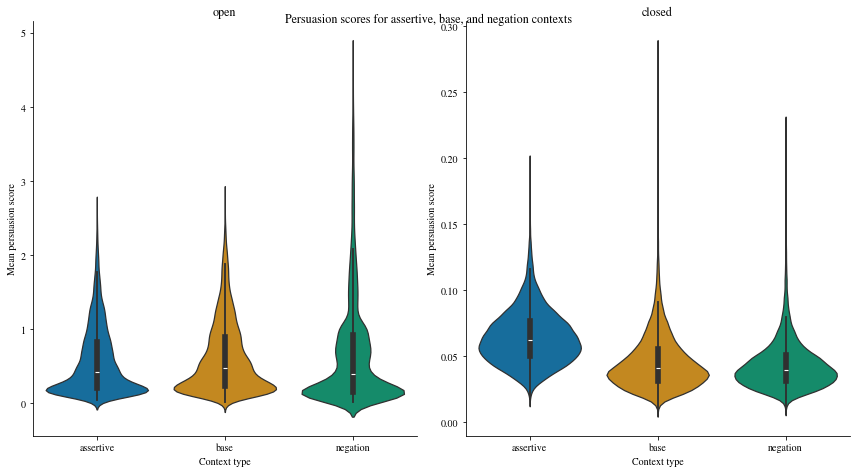

In [43]:
colormap = {
    "entities": REAL_COLOR,
    "gpt_fake_entities": FAKE_COLOR,
    "relevant": REAL_COLOR,
    "irrelevant": FAKE_COLOR,
}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
for i, qt in enumerate(p_score_per_context_type["query_type"].unique()):
    ax = axes[i]
    sns.violinplot(
        data=p_score_per_context_type[p_score_per_context_type["query_type"] == qt],
        x="context_types",
        y="mean_p_score",
        hue="context_types",
        # size=10,
        # dodge=True,
        # palette=[
        #     colormap[c]
        #     for c in p_score_per_context_type[
        #         "context_types"
        #     ].unique()
        # ],
        ax=ax,
    )
    ax.set_title(qt)
    ax.set_xlabel("Context type")
    ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores for assertive, base, and negation contexts",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_base_assertive_negation_contexts_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

# sns.violinplot(
#     data=p_score_per_context_type[p_score_per_context_type["query_type"] == "closed"],
#     x="query_type",
#     y="mean_p_score",
#     hue="context_types",
# )

In [71]:
# Tests for base vs assertive
(
    ttest_res_open_base_vs_assertive_df,
    ttest_res_closed_base_vs_assertive_df,
) = compute_ttest_scores_dfs(
    {
        qid: p_score_per_context_type[p_score_per_context_type["q_id"] == qid]
        for qid in p_score_per_context_type["q_id"].unique()
    },
    group1="assertive",
    group2="base",
    score_col="mean_p_score",
    type_col="context_types",
    alternative="greater",
    permutations=10000,
)

100%|██████████| 122/122 [00:12<00:00,  9.90it/s]


In [80]:
# Number and proportion of queries that are significant
print(
    "Open:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_open_base_vs_assertive_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="greater",
        ),
        indent=2,
    ),
)
print("\n")
print(
    "Closed:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_closed_base_vs_assertive_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="greater",
        ),
        indent=2,
    ),
)

Open:
{
  "count": {
    "significant (greater)": 2,
    "insignificant": 119
  },
  "proportion": {
    "significant (greater)": 0.01652892561983471,
    "insignificant": 0.9834710743801653
  }
}


Closed:
{
  "count": {
    "significant (greater)": 111,
    "insignificant": 10
  },
  "proportion": {
    "significant (greater)": 0.9173553719008265,
    "insignificant": 0.08264462809917356
  }
}


In [83]:
ttest_res_closed_base_vs_assertive_df["effect_size"].max()

5.945485176318425

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


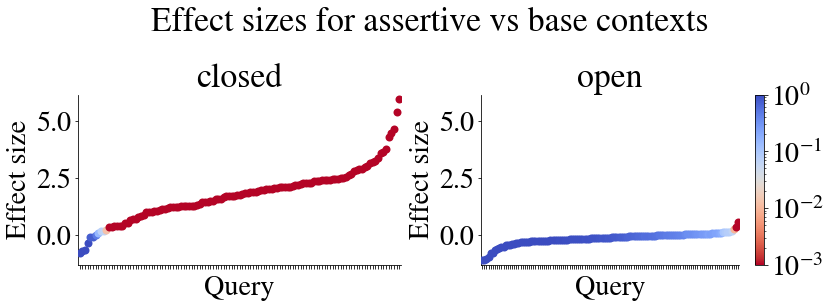

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i, (qt, df) in enumerate(
    {
        "closed": ttest_res_closed_base_vs_assertive_df.sort_values(by="effect_size"),
        "open": ttest_res_open_base_vs_assertive_df.sort_values(by="effect_size"),
    }.items()
):
    ax = axes[i]
    plot = sns.stripplot(
        data=df,
        x="query",
        y="effect_size",
        hue="p_value",
        ax=ax,
        size=8,
        # hue="is_real",
        # dodge=True,
        # hue_order=ENTITY_TYPES,
        legend=None,
        # palette=[colormap[e] for e in ENTITY_TYPES],
        # jitter=0.1,
        # legend="full",
        # cbar_kws={"ticks": [0, 0.05, 0, 95, 1]},
        # palette=df["color"].tolist(),
        palette=cm,
        hue_norm=matplotlib.colors.LogNorm(1e-3, 1),
    )
    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(15)
    ax.set(xticklabels=[])
    ax.set_title(qt)
    # ax.set_ylim(-6.5, 2)
    ax.set_xlabel("Query")
    ax.set_ylabel("Effect size")
    ax.set_ylim(
        min(
            ttest_res_open_base_vs_assertive_df["effect_size"].min(),
            ttest_res_closed_base_vs_assertive_df["effect_size"].min(),
        )
        - 0.2,
        max(
            ttest_res_open_base_vs_assertive_df["effect_size"].max(),
            ttest_res_closed_base_vs_assertive_df["effect_size"].max(),
        )
        + 0.2,
    )
# sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap)
# sm = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.NoNorm(), cmap=cmap)
sm = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(1e-3, 1), cmap=cm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
fig.suptitle("Effect sizes for assertive vs base contexts", y=0.9)
plt.tight_layout()
plot_name = f"plot_pscore_base_vs_assertive"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [74]:
# Tests for base vs negation
test_type = "two-sided"
(
    ttest_res_open_base_vs_negation_df,
    ttest_res_closee_base_vs_negation_df,
) = compute_ttest_scores_dfs(
    {
        qid: p_score_per_context_type[p_score_per_context_type["q_id"] == qid]
        for qid in p_score_per_context_type["q_id"].unique()
    },
    group1="negation",
    group2="base",
    score_col="mean_p_score",
    type_col="context_types",
    permutations=10000,
    alternative=test_type,
)

100%|██████████| 122/122 [00:12<00:00,  9.62it/s]


In [75]:
# Number and proportion of queries that are significant
print(
    "Open:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_open_base_vs_negation_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative=test_type,
        ),
        indent=2,
    ),
)
print("\n")
print(
    "Closed:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_closee_base_vs_negation_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative=test_type,
        ),
        indent=2,
    ),
)

Open:
{
  "count": {
    "significant (two-sided)": 90,
    "insignificant": 31
  },
  "proportion": {
    "significant (two-sided)": 0.743801652892562,
    "insignificant": 0.256198347107438
  }
}


Closed:
{
  "count": {
    "significant (two-sided)": 106,
    "insignificant": 15
  },
  "proportion": {
    "significant (two-sided)": 0.8760330578512396,
    "insignificant": 0.12396694214876033
  }
}


In [76]:
ttest_res_closee_base_vs_negation_df

,query,effect_size,p_value,n,bh_adj_p_value
0,http://schema.org/about,0.682079,0.0000,376,0.000000
1,http://yago-knowledge.org/resource/parallax,-0.645688,0.0000,300,0.000000
2,http://yago-knowledge.org/resource/notableWork,-1.168896,0.0000,312,0.000000
3,http://yago-knowledge.org/resource/mass,-0.719500,0.0000,300,0.000000
4,http://yago-knowledge.org/resource/length,-1.056420,0.0000,308,0.000000
...,...,...,...,...,...
116,reverse-http://yago-knowledge.org/resource/rep...,0.087861,0.4365,308,0.451423
117,reverse-http://schema.org/manufacturer,0.032653,0.7620,328,0.781373
118,http://schema.org/startDate,0.027369,0.7822,392,0.795346
119,reverse-http://schema.org/worksFor,-0.016775,0.8786,340,0.885922


/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


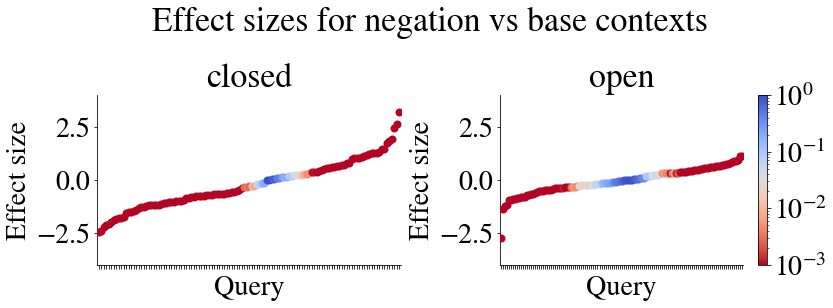

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i, (qt, df) in enumerate(
    {
        "closed": ttest_res_closee_base_vs_negation_df.sort_values(by="effect_size"),
        "open": ttest_res_open_base_vs_negation_df.sort_values(by="effect_size"),
    }.items()
):
    ax = axes[i]
    plot = sns.stripplot(
        data=df,
        x="query",
        y="effect_size",
        hue="p_value",
        ax=ax,
        size=8,
        # hue="is_real",
        # dodge=True,
        # hue_order=ENTITY_TYPES,
        legend=None,
        # palette=[colormap[e] for e in ENTITY_TYPES],
        # jitter=0.1,
        # legend="full",
        # cbar_kws={"ticks": [0, 0.05, 0, 95, 1]},
        # palette=df["color"].tolist(),
        palette=cm,
        hue_norm=matplotlib.colors.LogNorm(1e-3, 1),
    )
    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(15)
    ax.set(xticklabels=[])
    ax.set_title(qt)
    ax.set_ylim(-4, 4)
    ax.set_xlabel("Query")
    ax.set_ylabel("Effect size")
    # plt.colorbar(df["p_value"])
# sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap)
# sm = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.NoNorm(), cmap=cmap)
sm = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(1e-3, 1), cmap=cm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
fig.suptitle("Effect sizes for negation vs base contexts", y=0.9)
plt.tight_layout()
plot_name = f"plot_pscore_base_vs_negation"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [51]:
with pd.option_context(
    "display.max_rows", 10, "display.max_columns", None
):  # more options can be specified also
    display(
        ttest_res_closee_base_vs_negation_df[
            ttest_res_closee_base_vs_negation_df["effect_size"] < 0
        ].sort_values(by="effect_size")
    )

,query,effect_size,p_value,n,bh_adj_p_value
87,http://schema.org/alumniOf,-3.195324,0.0000,312,0.000000
65,http://schema.org/duns,-2.652609,0.0000,336,0.000000
32,reverse-http://schema.org/parentTaxon,-2.457127,0.0000,392,0.000000
31,reverse-http://schema.org/performer,-1.922721,0.0000,312,0.000000
52,http://schema.org/contentLocation,-1.849096,0.0000,392,0.000000
...,...,...,...,...,...
114,reverse-http://yago-knowledge.org/resource/dir...,-0.127784,0.2436,332,0.256310
115,reverse-http://schema.org/editor,-0.090289,0.4388,300,0.457714
116,reverse-http://yago-knowledge.org/resource/rep...,-0.087861,0.4459,308,0.461144
117,reverse-http://schema.org/manufacturer,-0.032653,0.7663,328,0.785782


In [52]:
with pd.option_context(
    "display.max_rows", 10, "display.max_columns", None
):  # more options can be specified also
    display(
        ttest_res_closee_base_vs_negation_df[
            ttest_res_closee_base_vs_negation_df["effect_size"] > 0
        ].sort_values(by="effect_size")
    )

,query,effect_size,p_value,n,bh_adj_p_value
120,reverse-http://yago-knowledge.org/resource/stu...,0.000915,0.9945,292,0.994500
119,reverse-http://schema.org/worksFor,0.016775,0.8756,340,0.882897
112,reverse-http://schema.org/musicBy,0.151583,0.1846,312,0.196466
110,http://yago-knowledge.org/resource/luminosity,0.162131,0.1605,300,0.174959
107,http://schema.org/isbn,0.180840,0.0744,388,0.083356
...,...,...,...,...,...
60,http://schema.org/deathDate,2.069794,0.0000,312,0.000000
64,http://schema.org/duration,2.127031,0.0000,388,0.000000
37,reverse-http://schema.org/homeLocation,2.200444,0.0000,308,0.000000
72,http://schema.org/neighbors,2.401640,0.0000,292,0.000000


/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='query_form', ylabel='persuasion_score'>

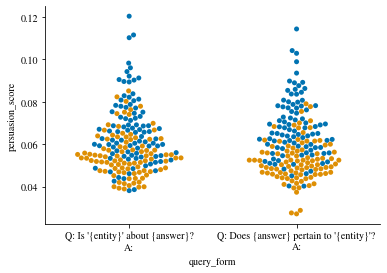

In [53]:
pscore_df = next(iter(qid_to_pscore_df.items()))[1]
sns.swarmplot(
    data=pscore_df[pscore_df["query_type"] == "closed"],
    x="query_form",
    y="persuasion_score",
    hue="type",
    legend=None,
)

In [54]:
mean_pscore_diffs = []
for qid, df in qid_to_pscore_df.items():
    wide_relevant_vs_irr_pscore_df = (
        df.groupby(["query_form", "type", "query_type"])
        .agg({"persuasion_score": "mean"})
        .reset_index()
        .pivot(
            index=["query_form", "query_type"],
            columns=["type"],
            values=["persuasion_score"],
        )
        .reset_index()
    )
    wide_relevant_vs_irr_pscore_df["pscore_diff"] = (
        wide_relevant_vs_irr_pscore_df[("persuasion_score", "mean_relevant_p_score")]
        - wide_relevant_vs_irr_pscore_df[
            ("persuasion_score", "mean_irrelevant_p_score")
        ]
    )
    wide_relevant_vs_irr_pscore_df[
        "mean_relevant_p_score"
    ] = wide_relevant_vs_irr_pscore_df[("persuasion_score", "mean_relevant_p_score")]
    wide_relevant_vs_irr_pscore_df[
        "mean_irrelevant_p_score"
    ] = wide_relevant_vs_irr_pscore_df[("persuasion_score", "mean_irrelevant_p_score")]

    wide_relevant_vs_irr_pscore_df["query"] = qid
    mean_pscore_diffs.append(
        wide_relevant_vs_irr_pscore_df[
            [
                "query",
                "query_type",
                "query_form",
                "pscore_diff",
                "mean_relevant_p_score",
                "mean_irrelevant_p_score",
            ]
        ]
    )

In [55]:
df

,query_type,query_form,type,persuasion_score
0,closed,Q: Is {entity} the terminus of {answer}?\nA:,mean_relevant_p_score,0.069700
1,closed,Q: Is {entity} the terminus of {answer}?\nA:,mean_relevant_p_score,0.069037
2,closed,Q: Is {entity} the terminus of {answer}?\nA:,mean_relevant_p_score,0.079446
3,closed,Q: Is {entity} the terminus of {answer}?\nA:,mean_relevant_p_score,0.081801
4,closed,Q: Is {entity} the terminus of {answer}?\nA:,mean_relevant_p_score,0.048205
...,...,...,...,...
595,open,{entity} is the terminus of,mean_irrelevant_p_score,2.114353
596,open,{entity} is the terminus of,mean_irrelevant_p_score,2.303181
597,open,{entity} is the terminus of,mean_irrelevant_p_score,2.372887
598,open,{entity} is the terminus of,mean_irrelevant_p_score,2.327570


/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


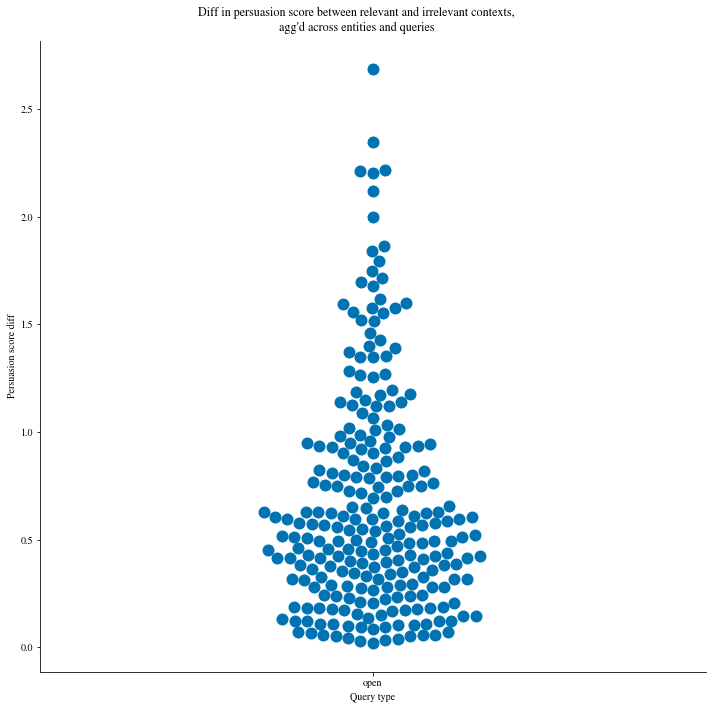

In [56]:
# Summary plot for the pscores across all queries (one dot is the pscore diff (averaged across all entities) for one query)
summary_pscores_across_queries = pd.concat(mean_pscore_diffs, axis=0)
fig, ax = plt.subplots(figsize=(10, 10))
sns.swarmplot(
    data=summary_pscores_across_queries[
        summary_pscores_across_queries["query_type"] == "open"
    ],
    x="query_type",
    y="pscore_diff",
    size=12,
    ax=ax,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Persuasion score diff")
fig.suptitle(
    "Diff in persuasion score between relevant and irrelevant contexts,\nagg'd across entities and queries"
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_relevant_irrelevant_contexts_agg_ents_and_queries"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

# Convert MultiIndex columns to tuples
tuples = summary_pscores_across_queries.columns.to_flat_index()

# Join tuple elements into a single string separated by underscore
new_column_names = [tup[0] for tup in tuples]

# Assign new column names to the DataFrame
summary_pscores_across_queries.columns = new_column_names

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


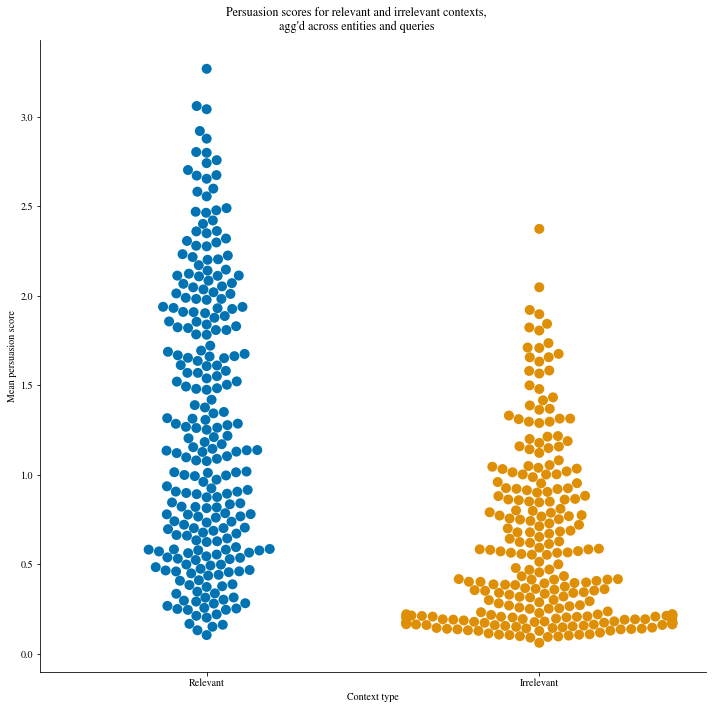

In [57]:
summary_pscores_across_queries_rel_and_irr = summary_pscores_across_queries.melt(
    id_vars=["query", "query_form", "query_type"],
    value_vars=["mean_relevant_p_score", "mean_irrelevant_p_score"],
    var_name="context_type",
    value_name="persuasion_score",
)
context_type_to_presentable = {
    "mean_relevant_p_score": "Relevant",
    "mean_irrelevant_p_score": "Irrelevant",
}
summary_pscores_across_queries_rel_and_irr[
    "presentable_context_type"
] = summary_pscores_across_queries_rel_and_irr["context_type"].apply(
    lambda x: context_type_to_presentable[x]
)

fig, ax = plt.subplots(figsize=(10, 10))
sns.swarmplot(
    data=summary_pscores_across_queries_rel_and_irr[
        summary_pscores_across_queries_rel_and_irr["query_type"] == "open"
    ],
    x="presentable_context_type",
    y="persuasion_score",
    hue="presentable_context_type",
    size=10,
    # dodge=True,
    ax=ax,
)
ax.set_xlabel("Context type")
ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores for relevant and irrelevant contexts,\nagg'd across entities and queries"
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_relevant_irrelevant_contexts_agg_ents_and_queries"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

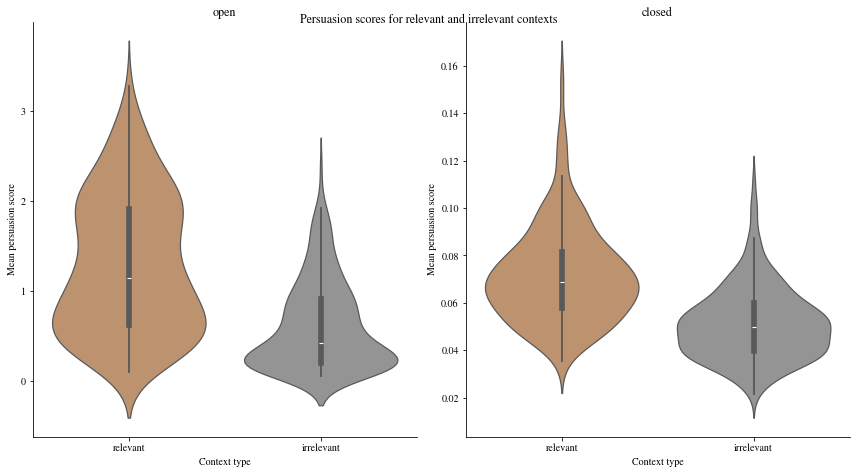

In [58]:
colormap = {
    "entities": REAL_COLOR,
    "gpt_fake_entities": FAKE_COLOR,
    "relevant": REAL_COLOR,
    "irrelevant": FAKE_COLOR,
}

summary_pscores_across_queries_rel_and_irr = summary_pscores_across_queries.melt(
    id_vars=["query", "query_form", "query_type"],
    value_vars=["mean_relevant_p_score", "mean_irrelevant_p_score"],
    var_name="context_type",
    value_name="persuasion_score",
)
context_type_to_presentable = {
    "mean_relevant_p_score": "relevant",
    "mean_irrelevant_p_score": "irrelevant",
}
summary_pscores_across_queries_rel_and_irr[
    "presentable_context_type"
] = summary_pscores_across_queries_rel_and_irr["context_type"].apply(
    lambda x: context_type_to_presentable[x]
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
for i, qt in enumerate(
    summary_pscores_across_queries_rel_and_irr["query_type"].unique()
):
    ax = axes[i]
    sns.violinplot(
        data=summary_pscores_across_queries_rel_and_irr[
            summary_pscores_across_queries_rel_and_irr["query_type"] == qt
        ],
        x="presentable_context_type",
        y="persuasion_score",
        hue="presentable_context_type",
        # size=10,
        # dodge=True,
        palette=[
            colormap[c]
            for c in summary_pscores_across_queries_rel_and_irr[
                "presentable_context_type"
            ].unique()
        ],
        ax=ax,
    )
    ax.set_title(qt)
    ax.set_xlabel("Context type")
    ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores for relevant and irrelevant contexts",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_relevant_irrelevant_contexts_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

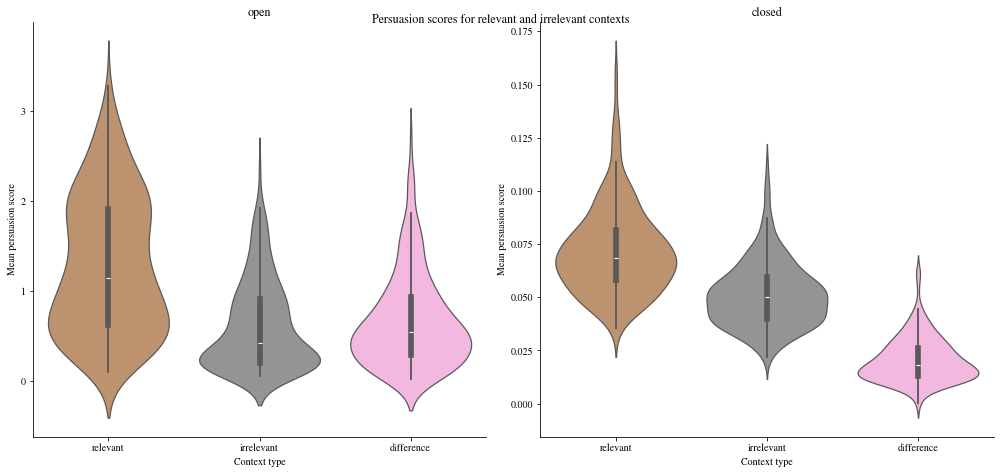

In [59]:
colormap = {
    "entities": REAL_COLOR,
    "gpt_fake_entities": FAKE_COLOR,
    "relevant": REAL_COLOR,
    "irrelevant": FAKE_COLOR,
    "difference": DIFF_COLOR,
}

summary_pscores_across_queries_rel_and_irr = summary_pscores_across_queries.melt(
    id_vars=["query", "query_form", "query_type"],
    value_vars=["mean_relevant_p_score", "mean_irrelevant_p_score", "pscore_diff"],
    var_name="context_type",
    value_name="persuasion_score",
)
context_type_to_presentable = {
    "mean_relevant_p_score": "relevant",
    "mean_irrelevant_p_score": "irrelevant",
    "pscore_diff": "difference",
}
summary_pscores_across_queries_rel_and_irr[
    "presentable_context_type"
] = summary_pscores_across_queries_rel_and_irr["context_type"].apply(
    lambda x: context_type_to_presentable[x]
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
for i, qt in enumerate(
    summary_pscores_across_queries_rel_and_irr["query_type"].unique()
):
    ax = axes[i]
    sns.violinplot(
        data=summary_pscores_across_queries_rel_and_irr[
            summary_pscores_across_queries_rel_and_irr["query_type"] == qt
        ],
        x="presentable_context_type",
        y="persuasion_score",
        hue="presentable_context_type",
        # size=10,
        # dodge=True,
        palette=[
            colormap[c]
            for c in summary_pscores_across_queries_rel_and_irr[
                "presentable_context_type"
            ].unique()
        ],
        ax=ax,
    )
    ax.set_title(qt)
    ax.set_xlabel("Context type")
    ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores for relevant and irrelevant contexts",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_relevant_irrelevant_contexts_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [60]:
ttest_res_open_p_df, ttest_res_closed_p_df = compute_ttest_scores_dfs(
    qid_to_pscore_df,
    group1="mean_irrelevant_p_score",
    group2="mean_relevant_p_score",
    score_col="persuasion_score",
    permutations=10000,
)

100%|██████████| 122/122 [00:12<00:00,  9.91it/s]


In [61]:
count_open_closed_sig_group_match(ttest_res_open_p_df, ttest_res_closed_p_df)

,query,open,closed
0,http://schema.org/about,less,less
1,http://yago-knowledge.org/resource/studentOf,less,less
2,http://yago-knowledge.org/resource/sportNumber,less,less
3,http://yago-knowledge.org/resource/replaces,less,less
4,http://yago-knowledge.org/resource/radialVelocity,less,less
...,...,...,...
114,http://yago-knowledge.org/resource/candidateIn,less,less
115,reverse-http://schema.org/lyricist,less,less
116,http://schema.org/knowsLanguage,less,less
117,http://schema.org/affiliation,less,less


In [62]:
# Number and proportion of queries that are significant
print(
    "Open:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_open_p_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)
print("\n")
print(
    "Closed:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_closed_p_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)

Open:
{
  "count": {
    "significant (less)": 119,
    "insignificant": 3
  },
  "proportion": {
    "significant (less)": 0.9754098360655737,
    "insignificant": 0.02459016393442623
  }
}


Closed:
{
  "count": {
    "significant (less)": 122,
    "insignificant": 0
  },
  "proportion": {
    "significant (less)": 1.0,
    "insignificant": 0.0
  }
}


In [63]:
p_score_test_results_by_qid = combine_open_and_closed_dfs(
    ttest_res_open_p_df, ttest_res_closed_p_df
)
p_score_test_results_by_qid

Open              Closed     
                 Cohen's $d$     $p$ Cohen's $d$  $p$
Query                                                
about              -0.440650  0.0000   -1.063597  0.0
academicDegree     -0.112050  0.1633   -0.582115  0.0
actor              -1.631888  0.0000   -1.384991  0.0
address            -1.548387  0.0000   -0.897578  0.0
administrates      -1.527218  0.0000   -0.795479  0.0
...                      ...     ...         ...  ...
studentOf          -1.127288  0.0000   -0.909872  0.0
studentsCount      -1.578532  0.0000   -0.731751  0.0
terminus           -0.737966  0.0000   -1.107385  0.0
unemploymentRate   -1.573209  0.0000   -0.796690  0.0
worksFor           -1.098975  0.0000   -1.759348  0.0

[122 rows x 4 columns]

In [64]:
print(
    write_to_latex_test_results_by_qid(
        p_score_test_results_by_qid,
        analysis_dir=analysis_dir,
        filename="p_score_test_results_by_qid.tex",
    )[:500]
)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{c}{Open} & \multicolumn{2}{c}{Closed} \\
 & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ \\
Query &  &  &  &  \\
\midrule
about & -0.44 & 0.00 & -1.06 & 0.00 \\
academicDegree & -0.11 & 0.16 & -0.58 & 0.00 \\
actor & -1.63 & 0.00 & -1.38 & 0.00 \\
address & -1.55 & 0.00 & -0.90 & 0.00 \\
administrates & -1.53 & 0.00 & -0.80 & 0.00 \\
affiliation & -0.21 & 0.04 & -1.74 & 0.00 \\
alumniOf & -1.04 & 0.00 & -2.02 & 0.00 \\
appearsIn & -0.20 & 0.04 & -1.03 


In [65]:
sus_and_persuasion_test_results_by_qid = pd.concat(
    [
        sus_score_test_results_by_qid,
        p_score_test_results_by_qid,
    ],
    keys=["Susceptibility", "Persuasion"],
    axis=1,
)
sus_and_persuasion_test_results_by_qid

Susceptibility                              Persuasion  \
                           Open              Closed                Open   
                    Cohen's $d$     $p$ Cohen's $d$     $p$ Cohen's $d$   
Query                                                                     
about                  0.019623  0.5544   -0.382451  0.0051   -0.440650   
academicDegree        -0.119443  0.2430   -0.501007  0.0036   -0.112050   
actor                 -1.898158  0.0000   -0.190876  0.0894   -1.631888   
address               -0.330559  0.0194    0.043635  0.6092   -1.548387   
administrates          0.218092  0.9020   -0.635561  0.0001   -1.527218   
...                         ...     ...         ...     ...         ...   
studentOf             -0.469149  0.0043   -0.222647  0.0976   -1.127288   
studentsCount         -0.596798  0.0004    0.765390  1.0000   -1.578532   
terminus               0.212625  0.8847   -1.080834  0.0000   -0.737966   
unemploymentRate      -0.411666  0.0101    1.179497  1.0000   -1.573209   
worksFor              -0.399704  0.0091   -0.488364  0.0013   -1.098975   

                                           
                              Closed       
                     $p$ Cohen's $d$  $p$  
Query                                      
about             0.0000   -1.063597  0.0  
academicDegree    0.1633   -0.582115  0.0  
actor             0.0000   -1.384991  0.0  
address           0.0000   -0.897578  0.0  
administrates     0.0000   -0.795479  0.0  
...                  ...         ...  ...  
studentOf         0.0000   -0.909872  0.0  
studentsCount     0.0000   -0.731751  0.0  
terminus          0.0000   -1.107385  0.0  
unemploymentRate  0.0000   -0.796690  0.0  
worksFor          0.0000   -1.759348  0.0  

[122 rows x 8 columns]

In [66]:
print(
    write_to_latex_test_sus_and_per_results_by_qid(
        sus_and_persuasion_test_results_by_qid,
        analysis_dir=analysis_dir,
        filename="sus_and_persuasion_test_results_by_qid.tex",
    )[:1000]
)

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{4}{c}{Susceptibility} & \multicolumn{4}{c}{Persuasion} \\
 & \multicolumn{2}{c}{Open} & \multicolumn{2}{c}{Closed} & \multicolumn{2}{c}{Open} & \multicolumn{2}{c}{Closed} \\
 & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ \\
Query &  &  &  &  &  &  &  &  \\
\midrule
about & 0.02 & 0.55 & -0.38 & 0.01 & -0.44 & 0.00 & -1.06 & 0.00 \\
academicDegree & -0.12 & 0.24 & -0.50 & 0.00 & -0.11 & 0.16 & -0.58 & 0.00 \\
actor & -1.90 & 0.00 & -0.19 & 0.09 & -1.63 & 0.00 & -1.38 & 0.00 \\
address & -0.33 & 0.02 & 0.04 & 0.61 & -1.55 & 0.00 & -0.90 & 0.00 \\
administrates & 0.22 & 0.90 & -0.64 & 0.00 & -1.53 & 0.00 & -0.80 & 0.00 \\
affiliation & -0.26 & 0.07 & -0.02 & 0.45 & -0.21 & 0.04 & -1.74 & 0.00 \\
alumniOf & -0.24 & 0.08 & -0.29 & 0.04 & -1.04 & 0.00 & -2.02 & 0.00 \\
appearsIn & -0.42 & 0.01 & 0.02 & 0.56 & -0.20 & 0.04 & -1.03 & 0.00 \\
author & -0.69 & 0.00 & -0.58 & 0.00 & -2.26 & 0.00 & -1.72 & 0.00 \

In [67]:
# # Plot context persuasion scores for every 10th query swarmplot, increasing according to the p-value
# qid_to_pscore_df_and_open_pvals = {
#     ttest_res_open_p_df.iloc[i]["query"]: (
#         ttest_res_open_p_df.iloc[i]["p_value"],
#         qid_to_pscore_df[ttest_res_open_p_df.iloc[i]["query"]],
#     )
#     for i in range(0, len(ttest_res_open_p_df), 10)
# }

# fig, axes = plt.subplots(
#     nrows=len(qid_to_pscore_df_and_open_pvals), ncols=1, figsize=(10, 120)
# )

# for i, (qid, (p_value, df)) in enumerate(qid_to_pscore_df_and_open_pvals.items()):
#     ax = axes[i]
#     plot = sns.swarmplot(
#         # data=val_df_per_qe[val_df_per_qe["query_type"] == "closed"],
#         data=df[df["query_type"] == "open"],
#         x="query_form",
#         y="persuasion_score",
#         hue="type",
#         ax=ax,
#         size=12,
#         dodge=True,
#         hue_order=reversed(sorted(df["type"].unique().tolist())),
#         # jitter=0.1,
#         # legend="full",
#     )
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(15)
#     ax.set_title(f"qid={qid}, pval={p_value:.3f}")
# fig.suptitle(
#     "Mean persuasion scores for relevant contexts vs irrelevant contexts, per entity"
# )
# plt.tight_layout()
# plt.subplots_adjust(top=0.97)
# plot_name = f"plot_pscore_vs_queryform_relevant_irrelevant_open_increasing_pval"
# save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
# fig.savefig(save_path, bbox_inches="tight")